# Discretization using Decision Trees

[Discretization using Decision Trees](https://towardsdatascience.com/discretisation-using-decision-trees-21910483fa4b)

[Supervised and Unsupervised Discretization of Continuous Features](http://ai.stanford.edu/~ronnyk/disc.pdf)

In [2]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

In [167]:
import os 
import sys

sys.path.append("../")

from titansurv.preprocessing import AutoFitTrans, ColumnDropper, NaNDropper

In [35]:
df = pd.read_csv("../data/raw/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [44]:
dfX = df.drop('Survived', axis=1)
dfy = df.Survived

Function to make columns ready for DecisionTree 

In [6]:
# TODO: Make it work for the case when x is a list
def select_clmns_dt(x, y, df):
    '''Ready columns for Decision Tree
    '''
    df = df.loc[:, [x, y]].dropna()
    X = df.iloc[:, 0].values.reshape(-1, 1) 
    y = df.iloc[:, -1].values
    
    return X, y

Extract Columns

In [7]:
X, y = select_clmns_dt('Age', 'Survived', df)

Fit DecisionTree

In [8]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Import required libraries to visualize the tree

In [9]:
from io import StringIO
import pydot
from IPython.display import Image
from sklearn.tree import export_graphviz

Maybe make this into a draw_decision_tree function?

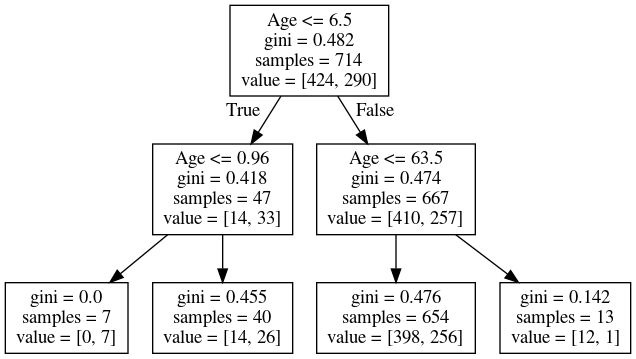

In [10]:
out = StringIO() # create output-object
export_graphviz(dt, out_file=out, feature_names=['Age']) # export dotdata to object
graph = pydot.graph_from_dot_data(out.getvalue())[0] # make a graph from dotdata
Image(graph.create_png()) # create png byte data from graph and visualize using Image


We have got 4 bins here, <br/> 
1. $\leq 0.96$
2. $\ (0.96, 6.5]$
3. $(6.5, 63.5]$
4. $\gt 63.5$

But these bins aren't the best, so we can tune the various hyperparameters and find the best bin for both.

First let us classify the categories. Every unique probability corresponds to a specific bin

In [11]:
df1 = df.loc[:, ['Age', 'Survived']]

In [12]:
try:
    df1['Age_tree'] = dt.predict_proba(df1.Age.values.reshape(-1, 1))[:, 0]
except ValueError as e:
    print(e)


Input contains NaN, infinity or a value too large for dtype('float32').


But as Decision Tree won't handle missing values, for now, we will impute the missing value with Mean

In [13]:
from sklearn.impute import SimpleImputer

In [14]:
imp = SimpleImputer()
X = imp.fit_transform(df.Age.values.reshape(-1, 1))
y = df.Survived

In [15]:
dt = DecisionTreeClassifier(max_depth=2).fit(X, y)

In [16]:
df1 = pd.DataFrame({'Age': X.ravel(), 'Survived': y})
df1['Age_tree'] = dt.predict_proba(X)[:, 0]
df1.head()

,Age,Survived,Age_tree
0,22.0,0,0.629362
1,38.0,1,0.629362
2,26.0,1,0.629362
3,35.0,1,0.629362
4,35.0,0,0.629362


In [17]:
res = df1.groupby('Age_tree').Age.aggregate([min, max], axis=0)
res

,min,max
Age_tree,,
0.000000,0.42,0.92
0.350000,1.00,6.00
0.629362,7.00,63.00
0.923077,64.00,80.00


In [18]:
cat_codes = dict(zip(res.index, np.argsort(res['min']).values))
cat_codes

{0.0: 0, 0.35: 1, 0.6293622141997594: 2, 0.9230769230769231: 3}

In [19]:
df1['Age_code'] = df1.Age_tree.map(cat_codes)
df1.head()

,Age,Survived,Age_tree,Age_code
0,22.0,0,0.629362,2
1,38.0,1,0.629362,2
2,26.0,1,0.629362,2
3,35.0,1,0.629362,2
4,35.0,0,0.629362,2


In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [21]:
pd.crosstab(df1.Survived, df1.Age_code, margins=True, normalize=True)

Age_code,0,1,2,3,All
Survived,,,,,
0,0.000000,0.015713,0.586981,0.013468,0.616162
1,0.007856,0.029181,0.345679,0.001122,0.383838
All,0.007856,0.044893,0.932660,0.014590,1.000000


In [54]:
?DecisionTreeClassifier

We can write a transformer which uses Decision Tree to Discretize column(s)

In [87]:
from sklearn.preprocessing import OrdinalEncoder

In [116]:
# NOTE: I have impl
class DecisionTreeDiscretizer(DecisionTreeClassifier):
    
    def __init__(self, criterion='gini',
                        splitter='best',
                        max_depth=None,
                        min_samples_split=2,
                        min_samples_leaf=1,
                        min_weight_fraction_leaf=0.0,
                        max_features=None,
                        random_state=None,
                        max_leaf_nodes=None,
                        min_impurity_decrease=0.0,
                        min_impurity_split=None,
                        class_weight=None,
                        presort='deprecated',
                        ccp_alpha=0.0):
        
        self.criterion = criterion
        self.splitter = splitter
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.class_weight = class_weight
        self.presort = presort
        self.ccp_alpha = ccp_alpha

        
    def transform(self, X, y=None):
        prob = self.predict_proba(X)
        return OneHotEncoder(drop='first', sparse=False).fit_transform(prob)
    
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)


In [117]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

Certain things to note:

1. For sequential operations on columns I have to use Pipelines
2. ColumnTransformer applies it's operations in parallel so if two steps are dependent it will be erroneous
3. column transformers expects numpy array and outputs numpy array, hence no label identifiers
4. If I use sequential operations I have to recode the logic of the transformers so as to enable passing of
   key label identifiers
   
Here is what I think for a specific pipeline I should do:
1. Divide the pipeline into three steps: Preprocessing_pre, Preprocessing, Model fitting
2. Combine the Preprocessing, Model fitting into a single Pipeline
3. Divide the Preprocessing_pre into parallel and sequential steps
4. Better to do the sequential steps using pandas if a recoding of logic is required, and package it into a general function to create multiple sub-pipelines
5. Dedicate a separate notebook for each?

In [118]:
encoder_cat_pipeline = Pipeline([
    ('imp', SimpleImputer()),
    ('discretizer', DecisionTreeDiscretizer())
])


preprocess = ColumnTransformer([
    ('imp_enc', encoder_cat_pipeline, ['Age']),
    ('dropper', 'drop', ['Embarked'])
], remainder='passthrough')


In [119]:
dfX_notna, dfy_notna = NaNDropper(['Age']).fit(dfX, dfy).transform(dfX, dfy)

In [120]:
DecisionTreeDiscretizer().fit_transform(dfX_notna.Age.values.reshape(-1, 1), dfy_notna)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [121]:
preprocess.fit_transform(dfX, dfy)

array([[0.0, 0.0, 0.0, ..., 'A/5 21171', 7.25, nan],
       [0.0, 0.0, 0.0, ..., 'PC 17599', 71.2833, 'C85'],
       [0.0, 0.0, 0.0, ..., 'STON/O2. 3101282', 7.925, nan],
       ...,
       [0.0, 0.0, 0.0, ..., 'W./C. 6607', 23.45, nan],
       [0.0, 0.0, 0.0, ..., '111369', 30.0, 'C148'],
       [0.0, 0.0, 0.0, ..., '370376', 7.75, nan]], dtype=object)

In [124]:
from titansurv.utils import print_params
print_params(preprocess)

['n_jobs',
 'remainder',
 'sparse_threshold',
 'transformer_weights',
 'transformers',
 'verbose',
 'imp_enc',
 'dropper',
 'imp_enc__memory',
 'imp_enc__steps',
 'imp_enc__verbose',
 'imp_enc__imp',
 'imp_enc__discretizer',
 'imp_enc__imp__add_indicator',
 'imp_enc__imp__copy',
 'imp_enc__imp__fill_value',
 'imp_enc__imp__missing_values',
 'imp_enc__imp__strategy',
 'imp_enc__imp__verbose',
 'imp_enc__discretizer__ccp_alpha',
 'imp_enc__discretizer__class_weight',
 'imp_enc__discretizer__criterion',
 'imp_enc__discretizer__max_depth',
 'imp_enc__discretizer__max_features',
 'imp_enc__discretizer__max_leaf_nodes',
 'imp_enc__discretizer__min_impurity_decrease',
 'imp_enc__discretizer__min_impurity_split',
 'imp_enc__discretizer__min_samples_leaf',
 'imp_enc__discretizer__min_samples_split',
 'imp_enc__discretizer__min_weight_fraction_leaf',
 'imp_enc__discretizer__presort',
 'imp_enc__discretizer__random_state',
 'imp_enc__discretizer__splitter']


Let's see if we can tune the hyperparameters of the DecisionTreeDiscretizer just for Age vs Survived

In [123]:
from sklearn.model_selection import GridSearchCV

In [126]:
max_features = ['sqrt', 'log2']
param_grid = {'imp_enc__discretizer__max_features' : max_features}
grid = GridSearchCV(preprocess, param_grid)
grid.fit(dfX, dfy)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('imp_enc',
                                 Pipeline(memory=None,
                                          steps=[('imp',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0)),
                                                 ('discretizer',
                                                  DecisionTreeDiscretizer(ccp_alpha=0.0,
                                                                          class_weight=None,
                                                                          criterion='gini',
                                                                          max_depth=None,
                                                                          max_features=None,
                                                                          max_leaf_nodes=None,
                                                                          min_impurity_decrease=0.0,
                                                                          min_impurity_split=None,
                                                                          min_samples_leaf=1,
                                                                          min_samples_split=2,
                                                                          min_weight_fraction_leaf=0.0,
                                                                          presort='deprecated',
                                                                          random_state=None,
                                                                          splitter='best'))],
                                          verbose=False),
                                 ['Age']),
                                ('dropper', 'drop', ['Embarked'])],
                  verbose=False) does not.

This won't work as our last step in the pipeline should have a predict method and a scoring method. So we need to make DecisionTreeDiscretizer our last step

In [138]:
class ColumnSelector(BaseEstimator, ClassifierMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X


In [146]:
preprocess = ColumnTransformer([
    ('imp', SimpleImputer(), ['Age']),
], remainder='drop')

pipe = Pipeline([
    ('preprocess', preprocess),
    ('discretizer', DecisionTreeDiscretizer())
])

In [149]:
print_params(pipe)

['memory',
 'steps',
 'verbose',
 'preprocess',
 'discretizer',
 'preprocess__n_jobs',
 'preprocess__remainder',
 'preprocess__sparse_threshold',
 'preprocess__transformer_weights',
 'preprocess__transformers',
 'preprocess__verbose',
 'preprocess__imp',
 'preprocess__imp__add_indicator',
 'preprocess__imp__copy',
 'preprocess__imp__fill_value',
 'preprocess__imp__missing_values',
 'preprocess__imp__strategy',
 'preprocess__imp__verbose',
 'discretizer__ccp_alpha',
 'discretizer__class_weight',
 'discretizer__criterion',
 'discretizer__max_depth',
 'discretizer__max_features',
 'discretizer__max_leaf_nodes',
 'discretizer__min_impurity_decrease',
 'discretizer__min_impurity_split',
 'discretizer__min_samples_leaf',
 'discretizer__min_samples_split',
 'discretizer__min_weight_fraction_leaf',
 'discretizer__presort',
 'discretizer__random_state',
 'discretizer__splitter']


In [165]:
min_samples_split = [2, 5, 10, 20]
max_depth = [None, 5, 10, 25, 50, 100]
min_samples_leaf = [1, 2, 5, 10]

param_grid = {
    'discretizer': [DecisionTreeDiscretizer()],
    'discretizer__min_samples_split': min_samples_split,
    'discretizer__max_depth': max_depth,
    'discretizer__min_samples_leaf': min_samples_leaf,
}

In [166]:
%%time
grid = GridSearchCV(pipe, param_grid)
grid.fit(dfX, dfy)

CPU times: user 4.58 s, sys: 0 ns, total: 4.58 s
Wall time: 4.61 s


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('imp',
                                                                         SimpleImputer(add_indicator=False,
                                                                                       copy=True,
                                                                                       fill_value=None,
                                                                                       missing_values=nan,
                                                      

In [160]:
print(grid.best_params_)
print(grid.best_score_)

{'discretizer': DecisionTreeDiscretizer(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=5, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'), 'discretizer__max_depth': 5, 'discretizer__max_features': 'sqrt', 'discretizer__min_samples_leaf': 5, 'discretizer__min_samples_split': 2}
0.6307576423325593


In [1]:
from sklearn.preprocessing import LabelEncoder

In [8]:
LabelEncoder().fit([1, 2, 1]).transform([[1], [2]])

array([0, 1])